# *IT00CH92 Embedded AI - Spring 2024*



# Training MNIST using TensorFlow

## Overview

To effectively deploy deep neural models on resource-constrained edge devices, two critical aspects of model optimization are most useful: pruning, which involves reducing the size of a neural network by eliminating unnecessary parameters, and quantization, which involves reducing the precision of numerical values in the model to conserve memory and computational resources.

For using these techniques, we define the application area by employing the popular LeNet-5 architecture trained on the classic MNIST dataset. LeNet-5, designed by Yann LeCun et al., represents one of the pioneering convolutional neural network (CNN) architectures and remains a benchmark for image classification tasks. At the end of the notebook, we obtain the trained full-precision model to be used for the further steps of the project.

## Setup

In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
tf.random.set_seed(
    seed=81
)

import tempfile
from tensorflow_model_optimization.python.core.keras.compat import keras
import tensorflow_model_optimization as tfmot
# from tensorflow.keras.models import load_model

/Users/mariamaoliveira/anaconda3/envs/embedded_ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using Tensorflow Datasets API to load MNIST

TFDS datasets often come with data already split into different sets. For MNIST, it has splits for train and test. We use the [Slicing API](https://www.tensorflow.org/datasets/splits#slicing_api) for TFDS to create a validation split.

Next, we aim to understand how the dataset is formatted and utilize visualizations. Finally, the dataset is preprocessed before being passed to the model. For preprocessing, we simply normalize the image values as float32 within the range [0, 1] for all three splits.

In [2]:
dataset, info = tfds.load('mnist', with_info=True, as_supervised=True)

In [3]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Input image shape: (28, 28, 1)
Image type: <dtype: 'uint8'>
Label shape: ()
Label type: <dtype: 'int64'>


2024-05-20 17:31:57.998153: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


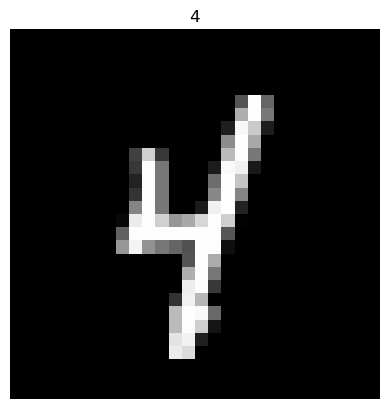

2024-05-20 17:31:58.069726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
ds = ds_train.take(1)  # Only take a single example
for example in ds:  # example is `('image': tf.Tensor, 'label': tf.Tensor)`
  image = example[0]
  label = example[1]
  print(f"Input image shape: {image.shape}\nImage type: {image.dtype}")
  print(f"Label shape: {label.shape}\nLabel type: {label.dtype}")
  plt.imshow(image, cmap='gray')
  plt.title(label.numpy())
  plt.axis("off")
  plt.show()

2024-05-20 14:25:09.913693: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-20 14:25:09.926189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


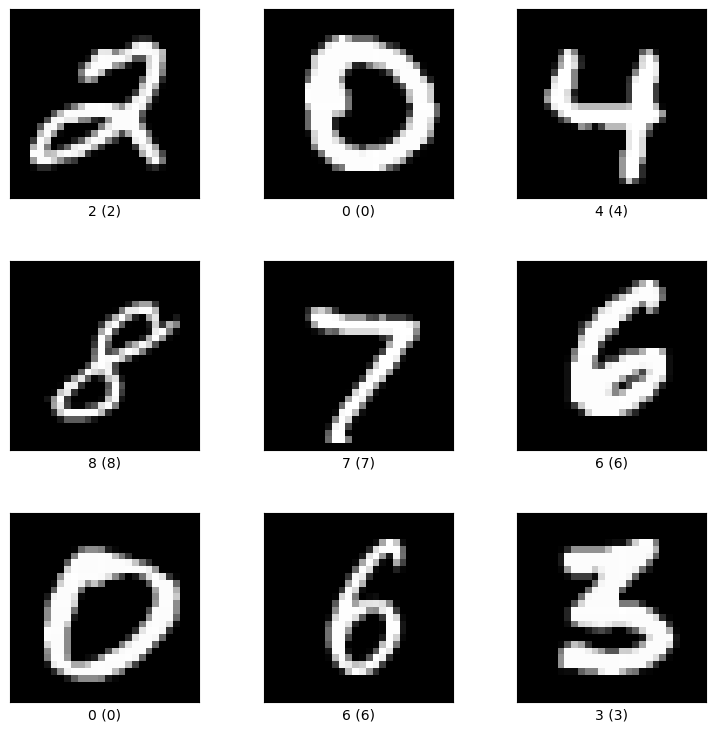

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

### Parameters

In [10]:
batch_size = 128
n_epochs = 4

### Preprocessing

In [15]:
def normalize_img(image:tf.uint8, label:tf.int64):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def normalize_splits(ds, split_name: str, batch_size: int):
  """Applies preprocessing to train, val and test sets"""
  ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
  )
  ds = ds.cache() # Caching makes it faster for consecutive runs
  if split_name != 'test':
    # Shuffling is not done for the test set
    ds = ds.shuffle(ds_info.splits[split_name].num_examples)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [16]:
ds_train = normalize_splits(ds_train, split_name='train[:90%]', batch_size=batch_size)
ds_val = normalize_splits(ds_val, split_name='train[90%:]', batch_size=batch_size)
ds_test = normalize_splits(ds_test, split_name='test', batch_size=batch_size)

In [17]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:


# tf.data.Dataset.from_tensor_slices((ds_train)).batch(1).take(100)

## Training Neural Network

In [34]:
# Define the model architecture (LeNet-5).

model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(120),
  keras.layers.Dense(84),
  keras.layers.Dense(10, activation='softmax')
])

# As truth labels are integer encoded, we use sparse categorical cross-entropy as loss fn
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # the ouputs are expected as probabilities
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [35]:
model.fit(
  ds_train,
  epochs=n_epochs,
  validation_data=ds_val,
)

Epoch 1/4
422/422 [==============================] - 11s 8ms/step - loss: 0.2383 - accuracy: 0.9295 - val_loss: 0.0843 - val_accuracy: 0.9742
Epoch 2/4
422/422 [==============================] - 2s 4ms/step - loss: 0.0711 - accuracy: 0.9786 - val_loss: 0.0665 - val_accuracy: 0.9805
Epoch 3/4
422/422 [==============================] - 2s 4ms/step - loss: 0.0546 - accuracy: 0.9832 - val_loss: 0.0730 - val_accuracy: 0.9775
Epoch 4/4
422/422 [==============================] - 2s 4ms/step - loss: 0.0447 - accuracy: 0.9857 - val_loss: 0.0514 - val_accuracy: 0.9860


In [36]:
_, baseline_accuracy = model.evaluate(
    ds_test, verbose=0)

print('Baseline test accuracy:', baseline_accuracy)

Baseline test accuracy: 0.9829999804496765


In [41]:
# Saving the model in .h5 format
keras.models.save_model(model, './Full_Precision_MNIST_TF.h5', include_optimizer=False)


<ipython-input-41-bb00b51b2b61>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, './Full_Precision_MNIST_TF.h5', include_optimizer=False)


## Conclusion

In this notebook, we trained a LeNet-5 neural network on the MNIST dataset using TensorFlow (and various of its APIs). It's important to note the size of the trained model in terms of the number of trainable parameters and the baseline test accuracy for further comparisons during the pruning and quantization steps.

# Pruning 

## Fine-tune pre-trained model with pruning

In [4]:
# # Load MNIST dataset
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# # Normalize the input image so that each pixel value is between 0 and 1.
# train_images = train_images / 255.0
# test_images = test_images / 255.0


# mnist = tf.keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# # Normalize the input image so that each pixel value is between 0 to 1.
# train_images = train_images.astype(np.float32) / 255.0
# test_images = test_images.astype(np.float32) / 255.0

In [18]:
keras_file = 'saved_model/Full_Precision_MNIST_TF.h5'
model = keras.models.load_model(keras_file)

In [19]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = len(ds_train)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 6)         308       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 6)         1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 14, 14, 16)        4818      
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 7, 7, 16)          1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

## Train and evaluate the model against baseline

In [20]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(ds_train,
                  batch_size=batch_size, epochs=epochs, validation_data=ds_val,
                  callbacks=callbacks)

Epoch 1/2


/Users/mariamaoliveira/anaconda3/envs/embedded_ai/lib/python3.10/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  6/422 [..............................] - ETA: 4s - loss: 0.0294 - accuracy: 0.9935   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0113s vs `on_train_batch_end` time: 0.0287s). Check your callbacks.


422/422 [==============================] - 12s 13ms/step - loss: 0.0398 - accuracy: 0.9876 - val_loss: 0.0505 - val_accuracy: 0.9835
Epoch 2/2
422/422 [==============================] - 5s 11ms/step - loss: 0.0318 - accuracy: 0.9901 - val_loss: 0.0479 - val_accuracy: 0.9862


In [23]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   ds_test, verbose=0)

print('Baseline test accuracy:', 0.9829999804496765) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9829999804496765
Pruned test accuracy: 0.9887999892234802


## Create 3x smaller models from pruning

In [24]:

#Do the pruning
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

# _, pruned_keras_file = tempfile.mkstemp('.h5')

pruned_keras_file = "saved model/pruned_model_1.h5"
keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

/var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/ipykernel_1768/2832786679.py:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model to: saved_model/pruned_model_1.h5


In [21]:
# # Converting to TensorFlowLite
# converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
# pruned_tflite_model = converter.convert()

# # _, pruned_tflite_file = tempfile.mkstemp('.tflite')
# pruned_tflite_file = "saved_model/pruned_model_tflite_1.tflite"

# with open(pruned_tflite_file, 'wb') as f:
#   f.write(pruned_tflite_model)

# print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpeldnjzxx/assets


INFO:tensorflow:Assets written to: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpeldnjzxx/assets


Saved pruned TFLite model to: saved_model/pruned_model_tflite_1.tflite


W0000 00:00:1716213379.869503 1430236 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1716213379.869523 1430236 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-20 16:56:19.869848: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpeldnjzxx
2024-05-20 16:56:19.871678: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-20 16:56:19.871694: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpeldnjzxx
2024-05-20 16:56:19.886369: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-05-20 16:56:19.924965: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpeldnjzxx
2024-05-20 16:56:19.941853: I tensorflow/cc/saved_model/loader.cc:

In [25]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  # _, zipped_file = tempfile.mkstemp('.zip')
  zipped_file = "saved_model/pruned_model_zipped_1.zip"
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [16]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 1200921.00 bytes
Size of gzipped pruned Keras model: 131239.00 bytes
Size of gzipped pruned TFlite model: 126999.00 bytes


## Create a 10x smaller model from combining pruning and quantization

Full integer quantization

In [14]:
pruned_model = keras.models.load_model("saved_model/pruned_model_1.h5")

In [28]:
def representative_data_gen():
  for image, label  in ds_train.take(100) :
    # image = tf.expand_dims(image, 0) 
    yield [image]

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpa3j93_38/assets


INFO:tensorflow:Assets written to: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpa3j93_38/assets
/Users/mariamaoliveira/anaconda3/envs/embedded_ai/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1716216203.170832   17487 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1716216203.170840   17487 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-20 17:43:23.170949: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpa3j93_38
2024-05-20 17:43:23.171490: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-20 17:43:23.171495: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/s7/3gb_v_vn6ns01664c_jtg6hh0000gn/T/tmpa3j93_38
2024-05-20 17:43:2

In [32]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset #provide part of the dataset
# # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # converter.inference_input_type = tf.int8  # or tf.uint8
# # converter.inference_output_type = tf.int8  # or tf.uint8
# quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

quantized_and_pruned_tflite_file = "saved_model/pruned_model_tflite_quantized_1.tflite"

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(tflite_model_quant)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

Saved quantized and pruned TFLite model to: saved_model/pruned_model_tflite_quantized_1.tflite
Size of gzipped baseline Keras model: 1200921.00 bytes
Size of gzipped pruned and quantized TFlite model: 97094.00 bytes


See persistence of accuracy from TF to TFLite

In [51]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    test_image = np.expand_dims(test_image, axis=-1).astype(np.float32)
    # print(test_image.shape)
    # print(test_image)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)
print('Pruned TF test accuracy:', model_for_pruning_accuracy)

# Convert the model to .h

In [33]:
!echo "const unsigned char model[] = {" > classifying_imu/content/model.h
!cat saved_model/pruned_model_tflite_quantized_1.tflite | xxd -i      >> classifying_imu/content/model.h
!echo "};"                              >> classifying_imu/content/model.h

import os
model_h_size = os.path.getsize("classifying_imu/content/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 698,052 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
